<a href="https://colab.research.google.com/github/techpvk/EVR1/blob/main/s7/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

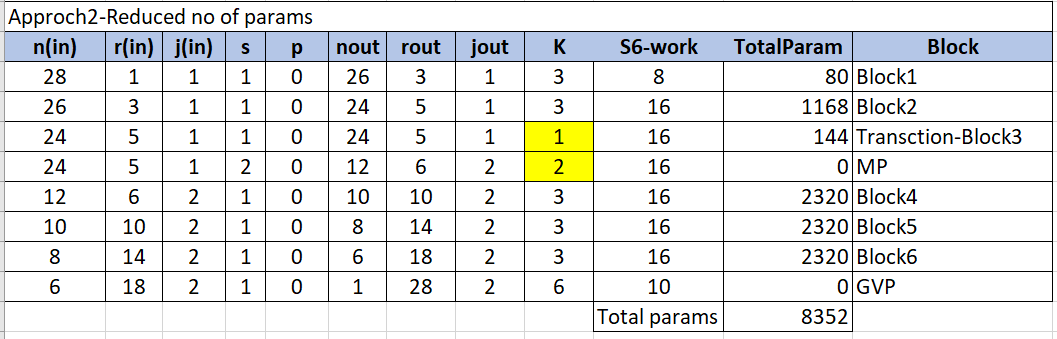

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [13]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13347870111465454 Batch_id=468 Accuracy=86.76: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.1248, Accuracy: 9637/10000 (96.37%)

EPOCH: 1


Loss=0.047316472977399826 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]



Test set: Average loss: 0.0687, Accuracy: 9796/10000 (97.96%)

EPOCH: 2


Loss=0.03222872316837311 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]



Test set: Average loss: 0.0555, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


Loss=0.022946057841181755 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0396, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.08031545579433441 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]



Test set: Average loss: 0.0379, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.09419659525156021 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]



Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.025385333225131035 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]



Test set: Average loss: 0.0272, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.06184602156281471 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]



Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.0711260735988617 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]



Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.015914106741547585 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.04191574826836586 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.031673070043325424 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.029494749382138252 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]



Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.07489646971225739 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]



Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.016258956864476204 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]



Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.13481828570365906 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.03162360563874245 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.07446576654911041 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]



Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.016512511298060417 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.040567319840192795 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)



In [17]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

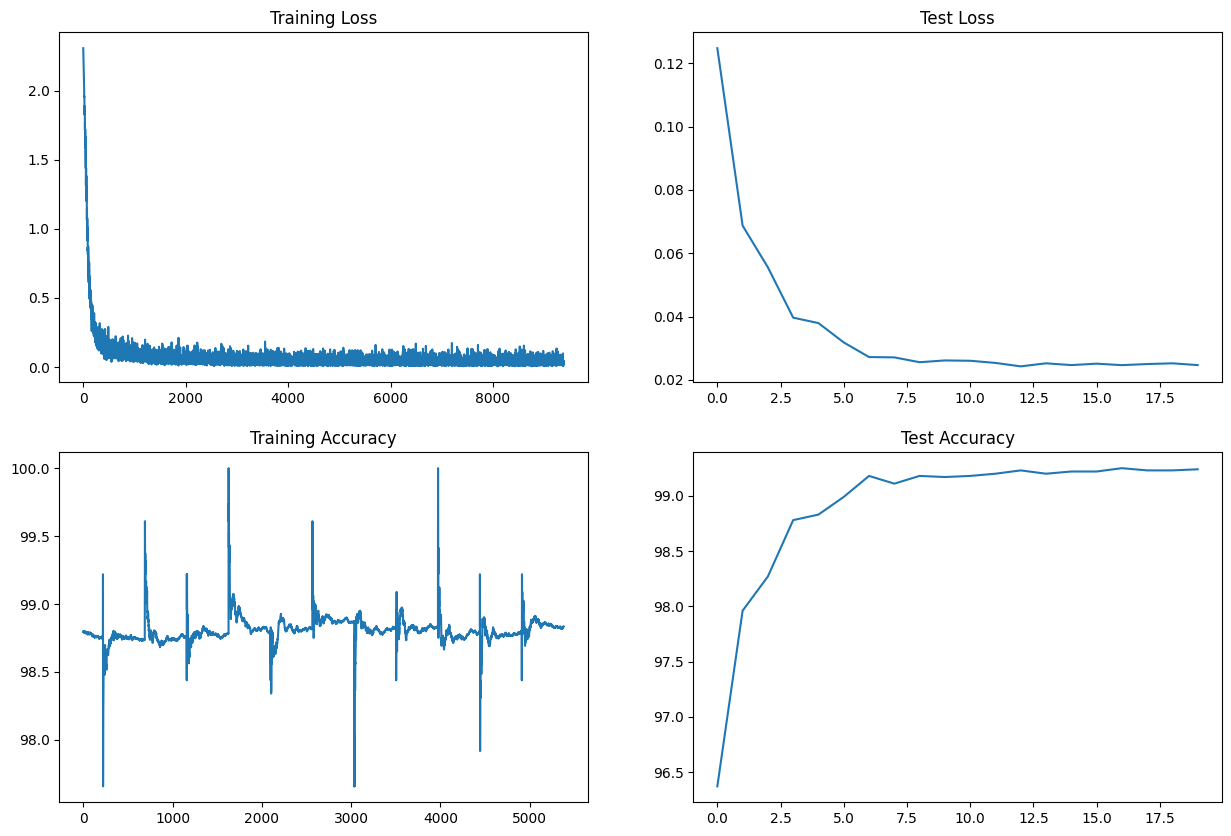

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")